In [1]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "fashion-mnist_train.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "zalando-research/fashionmnist",
  file_path,
)

/tmp/ipython-input-1251482784.py:6: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'fashionmnist' dataset.


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

xtrain, xtest, ytrain, ytest = train_test_split(X, y, shuffle=True, random_state=42)

xtrain = xtrain/255
xtest = xtest/255

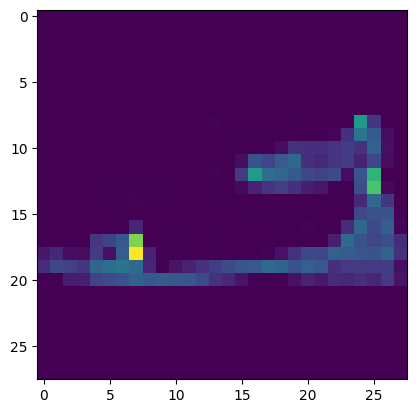

In [5]:
plt.imshow(xtrain.iloc[9, :].values.reshape(28,28))

In [6]:
class CustomDataset(Dataset):

    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [ ]:
xtrain_tensor = torch.from_numpy(xtrain.values).float()
xtest_tensor = torch.from_numpy(xtest.values).float()
ytrain_tensor = torch.from_numpy(ytrain.values).float()
ytest_tensor = torch.from_numpy(ytest.values).float()

In [ ]:
traindataset = CustomDataset(xtrain_tensor, ytrain_tensor)
testdataset = CustomDataset(xtest_tensor, ytest_tensor)

In [61]:
class MyNN(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_layers, neurons_per_layer, activation, dropout_per_layer):

        super().__init__()

        layers = []

        activation = getattr(nn, activation)

        for neuron in neurons_per_layer:
            layers.append(nn.Linear(input_dim, neuron))
            layers.append(nn.BatchNorm1d(neuron))
            layers.append(activation())
            layers.append(nn.Dropout(0.3))
            input_dim = neuron

        layers.append(nn.Linear(input_dim, output_dim))

        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
# objective

def objective(trail):

    num_hidden_layers = trail.suggest_int("num_hidden_layers", 1, 5)

    neurons_per_layers = []
    dropout_rate = []
    for i in range(num_hidden_layers):
        neurons_per_layers.append(trail.suggest_int(f"neurons_in_layers_{i}", 8, 128, step=8))
        dropout_rate.append(trail.suggest_float(f"dropout_{i}", 0.1, 0.5, step=0.1))

    epochs = trail.suggest_int("epochs", 10, 50, step=8)
    learning_rate = trail.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    batch_size = trail.suggest_categorical("batch_size", [16, 32, 64, 128])
    optimizer_name = trail.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
    activation_name = trail.suggest_categorical("activation", ['Sigmoid', 'ReLU', 'Tanh'])
    weight_decay = trail.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

    traindataloader = DataLoader(traindataset, batch_size=batch_size, shuffle=True)
    testdataloader = DataLoader(testdataset, batch_size=batch_size)

    input_dim = 784
    output_dim = 10

    model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layers, activation_name, dropout_rate)
    model.to(device)

    loss_function = nn.CrossEntropyLoss()

    optimizer_obj = getattr(torch.optim, optimizer_name)
    optimizer = optimizer_obj(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(epochs):

        for batch_features, batch_labels in traindataloader:

            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            ypred = model(batch_features)

            loss = loss_function(ypred, batch_labels.long())

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
    
    model.eval()

    total = 0
    correct = 0

    with torch.no_grad():
        
        for batch_features, batch_labels in testdataloader:

            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            outputs = model(batch_features)

            predicted = torch.argmax(outputs, dim=1)

            total = total + batch_labels.shape[0]

            correct = correct + (predicted == batch_labels).sum().item()

        accuracy = correct / total
    
    return accuracy

In [16]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.2 MB/s eta 0:00:0000:01


In [72]:
import optuna

study = optuna.create_study(direction='maximize')

[I 2026-01-04 09:22:23,625] A new study created in memory with name: no-name-61623f6b-b230-40a8-abe8-d0bcbcd8644a


In [73]:
study.optimize(objective, n_trials=1)

[I 2026-01-04 09:23:18,294] Trial 0 finished with value: 0.7921333333333334 and parameters: {'num_hidden_layers': 2, 'neurons_in_layers_0': 32, 'dropout': 0.2, 'neurons_in_layers_1': 48, 'epochs': 34, 'learning_rate': 0.009403717623567617, 'batch_size': 128, 'optimizer': 'RMSprop', 'activation': 'Sigmoid', 'weight_decay': 0.00025049673574068795}. Best is trial 0 with value: 0.7921333333333334.


In [74]:
study.best_value

0.7921333333333334

In [75]:
study.best_params

{'num_hidden_layers': 2,
 'neurons_in_layers_0': 32,
 'dropout': 0.2,
 'neurons_in_layers_1': 48,
 'epochs': 34,
 'learning_rate': 0.009403717623567617,
 'batch_size': 128,
 'optimizer': 'RMSprop',
 'activation': 'Sigmoid',
 'weight_decay': 0.00025049673574068795}